In [ ]:
!unzip orange-diseases-dataset.zip -d orange-diseases-dataset

Archive:  orange-diseases-dataset.zip.zip
warning [orange-diseases-dataset.zip.zip]:  1048576 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  1048576
  (attempting to re-compensate)
  inflating: orange-diseases-dataset/test/blackspot/b (1).jpg  
error: not enough memory for bomb detection


In [ ]:
!unzip test.zip -d test

Archive:  test.zip
   creating: test/test/
   creating: test/test/blackspot/
  inflating: test/test/blackspot/b (1).jpg  
  inflating: test/test/blackspot/b (10).jpg  
  inflating: test/test/blackspot/b (11).jpg  
  inflating: test/test/blackspot/b (12).jpg  
  inflating: test/test/blackspot/b (13).jpg  
  inflating: test/test/blackspot/b (14).jpg  
  inflating: test/test/blackspot/b (15).jpg  
  inflating: test/test/blackspot/b (16).jpg  
  inflating: test/test/blackspot/b (17).jpg  
  inflating: test/test/blackspot/b (18).jpg  
  inflating: test/test/blackspot/b (19).jpg  
  inflating: test/test/blackspot/b (2).jpg  
  inflating: test/test/blackspot/b (20).jpg  
  inflating: test/test/blackspot/b (21).jpg  
  inflating: test/test/blackspot/b (22).jpg  
  inflating: test/test/blackspot/b (3).jpg  
  inflating: test/test/blackspot/b (4).jpg  
  inflating: test/test/blackspot/b (5).jpg  
  inflating: test/test/blackspot/b (6).jpg  
  inflating: test/test/blackspot/b (7).jpg  
  inflatin

In [ ]:
!unzip train.zip -d train

Archive:  train.zip
   creating: train/train/
   creating: train/train/blackspot/
  inflating: train/train/blackspot/b (1).jpg  
  inflating: train/train/blackspot/b (10).jpg  
  inflating: train/train/blackspot/b (100).jpg  
  inflating: train/train/blackspot/b (101).jpg  
  inflating: train/train/blackspot/b (102).jpg  
  inflating: train/train/blackspot/b (103).jpg  
  inflating: train/train/blackspot/b (104).jpg  
  inflating: train/train/blackspot/b (105).jpg  
  inflating: train/train/blackspot/b (106).jpg  
  inflating: train/train/blackspot/b (107).jpg  
  inflating: train/train/blackspot/b (108).jpg  
  inflating: train/train/blackspot/b (109).jpg  
  inflating: train/train/blackspot/b (11).jpg  
  inflating: train/train/blackspot/b (110).jpg  
  inflating: train/train/blackspot/b (111).jpg  
  inflating: train/train/blackspot/b (112).jpg  
  inflating: train/train/blackspot/b (113).jpg  
  inflating: train/train/blackspot/b (114).jpg  
  inflating: train/train/blackspot/b (11

In [ ]:
# 라이브러리 설치
!pip install transformers datasets torch torchvision sklearn matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from transformers import ViTForImageClassification, ViTFeatureExtractor, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt


# 데이터 경로 설정
data_dir = "/content/orange-diseases-dataset"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# 클래스 확인
classes = os.listdir(train_dir)
print("클래스 목록:", classes)


클래스 목록: ['blackspot', 'canker', 'grenning', 'fresh']


In [ ]:
# 데이터 전처리 및 증강
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# 데이터 로딩
train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

class ViTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return {'pixel_values': image, 'labels': label}

train_ds = ViTDataset(train_dataset)
test_ds = ViTDataset(test_dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


파라미터 튜닝

In [ ]:
# EarlyStopping 추가 (콜백 활용)
from transformers import EarlyStoppingCallback

# 모델 설정
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(train_dataset.classes),
    id2label={str(i): label for i, label in enumerate(train_dataset.classes)},
    label2id={label: str(i) for i, label in enumerate(train_dataset.classes)}
)

# 학습 인자 설정 >> epoch 추가, 배치사이즈 변경, 학습률 변경, Early stopping 추가
training_args = TrainingArguments(
    output_dir='./vit_orange_finetune',
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    learning_rate=1e-5,
    logging_dir='./logs'
)

# 평가 함수 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

# 모델 학습
train_results = trainer.train()



config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gwshim (gwshim-ktb) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.703095,0.909091
2,No log,0.371259,0.969697
3,No log,0.270063,0.959596
4,No log,0.217392,0.979798
5,No log,0.197314,0.979798
6,No log,0.190802,0.979798


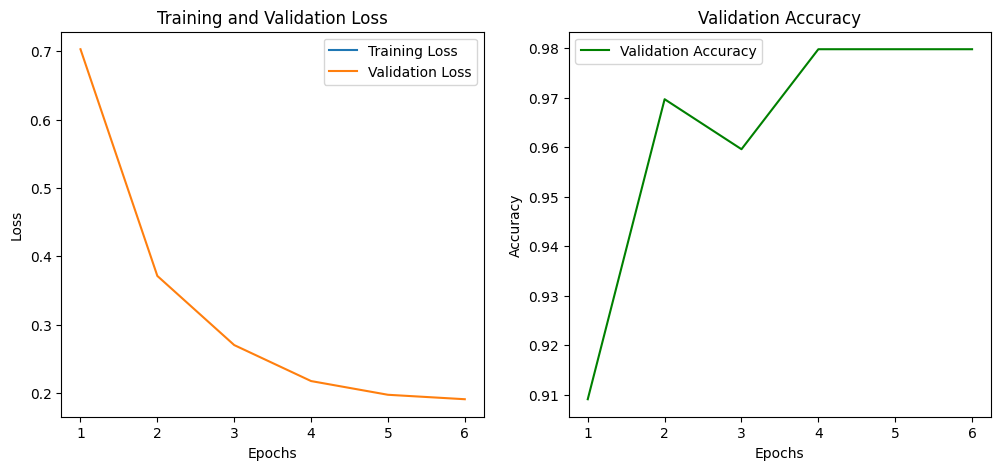

테스트 데이터 정확도: 0.9798


In [ ]:
# 학습 로그에서 loss와 accuracy 추출
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log.keys()]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log.keys()]
eval_accuracy = [log['eval_accuracy'] for log in trainer.state.log_history if 'eval_accuracy' in log.keys()]

# 손실과 정확도 시각화
plt.figure(figsize=(12, 5))

# 손실 곡선
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(eval_loss) + 1), eval_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 정확도 곡선
plt.subplot(1, 2, 2)
plt.plot(range(1, len(eval_accuracy) + 1), eval_accuracy, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()

# 최종 평가 및 결과 출력
metrics = trainer.evaluate()
print(f"테스트 데이터 정확도: {metrics['eval_accuracy']:.4f}")
